In [5]:
import numpy as np
import matplotlib.pyplot as plt
from simtk import unit

# Langevin NVT

To easily run tests with langevin dynamics, the method `simulations.langevin_NVT` provides a simple interface. Let's first of all see a simple example on how to use it:

In [15]:
from uibcdf_test_systems.simulation import langevin_NVT
from uibcdf_test_systems import FreeParticle

free_particle = FreeParticle(n_particles=1, mass=10*unit.amu)

initial_positions = np.zeros((1,3),dtype=float)*unit.nanometers
initial_velocities = np.zeros((1,3),dtype=float)*unit.nanometers/unit.picometers

time, position, velocity, kinetic_energy, potential_energy = langevin_NVT(system=free_particle.system, temperature=300*unit.kelvin,
                                                                         friction=1.0/unit.picoseconds, initial_positions=initial_positions,
                                                                         initial_velocities=initial_velocities, integration_timestep=0.1*unit.picoseconds,
                                                                         saving_timestep=1.0*unit.picoseconds, total_time=0.5*unit.nanoseconds)


Every method in the module `simulation` has at least five possible output arguments: `time`, `position`, `velocity`, `kinetic_energy` and `potential_energy`.

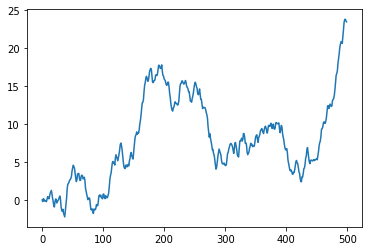

In [16]:
plt.plot(time, position[:,0,0])

In [ ]:
# %load ../../uibcdf_test_systems/simulation/langevin_NVT.py

def langevin_NVT(system, temperature=None, friction=None,
                 initial_positions=None, initial_velocities=None, integration_timestep=None,
                 saving_timestep=None, total_time=None, platform_name='CPU', verbose=True):


    from simtk.openmm import LangevinIntegrator, Platform, Context
    from simtk import unit
    import numpy as np

    # System parameters.
    n_particles = system.getNumParticles()

    # Integration parameters.

    steps_per_cicle = int(round(saving_timestep/integration_timestep))
    n_steps = int(round(total_time/integration_timestep))
    n_cicles = int(round(n_steps/steps_per_cicle))

    # Integrator.

    integrator = LangevinIntegrator(temperature, friction, integration_timestep)

    # Platform.

    platform = Platform.getPlatformByName(platform_name)

    # Context.

    context = Context(system, integrator, platform)
    context.setPositions(initial_positions)
    context.setVelocities(initial_velocities)

    # Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

    time = np.zeros([n_cicles], np.float32) * unit.picoseconds
    position = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
    velocity = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
    kinetic_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole
    potential_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole

    # Initial context in reporters

    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[0] = state.getTime()
    position[0] = state.getPositions()
    velocity[0] = state.getVelocities()
    kinetic_energy[0] = state.getKineticEnergy()
    potential_energy[0] = state.getPotentialEnergy()

    # Integration loop saving every cicle steps

    for ii in range(1, n_cicles):
        context.getIntegrator().step(steps_per_cicle)
        state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
        time[ii] = state.getTime()
        position[ii] = state.getPositions()
        velocity[ii] = state.getVelocities()
        kinetic_energy[ii] = state.getKineticEnergy()
        potential_energy[ii] = state.getPotentialEnergy()

    return time, position, velocity, kinetic_energy, potential_energy
